In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Datetime parser

def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

In [ ]:
# Load dataset

dataset = pd.read_csv('/content/drive/My Drive/Datasets/birth.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

dataset.head()

Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: Births, dtype: int64

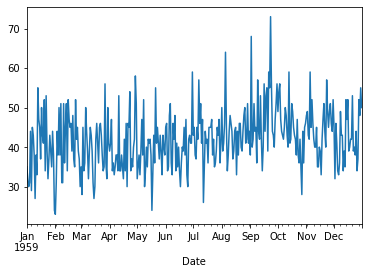

In [ ]:
# Plot dataset

dataset.plot()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

Processing Time-Series Data

In [ ]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# #invert differenced value
# def inverse_difference(history, yhat, interval=1):
#   return yhat + history[-interval]

In [ ]:
# # scale train dan test data to [-1, 1]
# def scale(train, test):
#   # fit scaler
#   scaler = MinMaxScaler(feature_range=(-1,1))
#   scaler = scaler.fit(train)
#   #transform train
#   train = train.reshape(train.shape[0], train.shape[1])
#   train_scaled = scaler.transform(train)
#   #transform test
#   test = test.reshape(test.shape[0], test.shape[1])
#   test_scaled = scaler.transform(test)
#   return scaler, train_scaled, test_scaled

# # inverse scaling for a forecasted value
# def invert_scale(scaler, X, yhat):
#   new_row = [x for x in X] + [yhat]
#   array = np.array(new_row)
#   array = array.reshape(1, len(array))
#   inverted = scaler.inverse_transform(array)
#   return inverted[0, -1]

In [ ]:
lag = 1

# transform data to be stationary
raw_values = dataset.values
raw_values
diff_values = difference(raw_values, 1)
diff_values

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag)
supervised
supervised_values = supervised.values[lag:, :]
supervised_values

array([[ -3.,  -2.],
       [ -2.,   1.],
       [  1.,  13.],
       [ 13., -15.],
       [-15.,  16.],
       [ 16.,  -2.],
       [ -2.,  -5.],
       [ -5., -11.],
       [-11.,  11.],
       [ 11.,  -5.],
       [ -5.,  22.],
       [ 22.,  -8.],
       [ -8.,  -2.],
       [ -2.,  -8.],
       [ -8.,  13.],
       [ 13.,  -7.],
       [ -7.,  -2.],
       [ -2.,  11.],
       [ 11., -18.],
       [-18.,  19.],
       [ 19., -14.],
       [-14.,  -7.],
       [ -7.,   5.],
       [  5.,   6.],
       [  6.,  -4.],
       [ -4.,  -4.],
       [ -4.,   9.],
       [  9.,  -6.],
       [ -6., -14.],
       [-14.,  -1.],
       [ -1.,   8.],
       [  8.,  13.],
       [ 13.,  -6.],
       [ -6.,  12.],
       [ 12., -12.],
       [-12.,  13.],
       [ 13., -20.],
       [-20.,   0.],
       [  0.,  20.],
       [ 20., -15.],
       [-15.,   9.],
       [  9.,   6.],
       [  6., -17.],
       [-17.,  18.],
       [ 18.,  -5.],
       [ -5.,  -2.],
       [ -2.,   1.],
       [  1.,

In [ ]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [ ]:
train_scaled

array([[-1.37931034e-01, -1.03448276e-01],
       [-1.03448276e-01, -6.93889390e-17],
       [-6.93889390e-17,  4.13793103e-01],
       [ 4.13793103e-01, -5.51724138e-01],
       [-5.51724138e-01,  5.17241379e-01],
       [ 5.17241379e-01, -1.03448276e-01],
       [-1.03448276e-01, -2.06896552e-01],
       [-2.06896552e-01, -4.13793103e-01],
       [-4.13793103e-01,  3.44827586e-01],
       [ 3.44827586e-01, -2.06896552e-01],
       [-2.06896552e-01,  7.24137931e-01],
       [ 7.24137931e-01, -3.10344828e-01],
       [-3.10344828e-01, -1.03448276e-01],
       [-1.03448276e-01, -3.10344828e-01],
       [-3.10344828e-01,  4.13793103e-01],
       [ 4.13793103e-01, -2.75862069e-01],
       [-2.75862069e-01, -1.03448276e-01],
       [-1.03448276e-01,  3.44827586e-01],
       [ 3.44827586e-01, -6.55172414e-01],
       [-6.55172414e-01,  6.20689655e-01],
       [ 6.20689655e-01, -5.17241379e-01],
       [-5.17241379e-01, -2.75862069e-01],
       [-2.75862069e-01,  1.37931034e-01],
       [ 1.

## Baseline Model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_baseline = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1080 - val_loss: 0.0690
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1068 - val_loss: 0.0683
Epoch 3/1000
9/9 [==============================] - 0s 2ms/step - loss: 0.1059 - val_loss: 0.0675
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1049 - val_loss: 0.0668
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1042 - val_loss: 0.0662
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1034 - val_loss: 0.0656
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1028 - val_loss: 0.0654
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1021 - val_loss: 0.0650
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1015 - val_loss: 0.0645
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1010 - val_loss: 0.0642
Epoch 11/1000
9/9 

In [ ]:
loss = model.evaluate(feature_test, verbose=2)

print("Test loss:", loss)

3/3 - 0s - loss: 0.0000e+00
Test loss: 0.0


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

In [ ]:
history_baseline_dataframe = pd.DataFrame(history_baseline.history)
history_baseline_dataframe['epoch'] = history_baseline.epoch
history_baseline_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
136,0.087380,0.056723,136
137,0.087342,0.056725,137
135,0.087347,0.056727,135
134,0.087406,0.056737,134
208,0.087036,0.056738,208
...,...,...,...
4,0.104193,0.066155,4
3,0.104931,0.066847,3
2,0.105858,0.067529,2
1,0.106817,0.068258,1


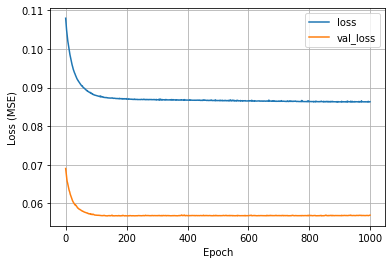

In [ ]:
plot_loss(history_baseline)

## Deeper Model

In [ ]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.1762 - val_loss: 0.0990
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1641 - val_loss: 0.0932
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1558 - val_loss: 0.0889
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1482 - val_loss: 0.0859
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1429 - val_loss: 0.0836
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1384 - val_loss: 0.0817
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1346 - val_loss: 0.0802
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1315 - val_loss: 0.0788
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1287 - val_loss: 0.0775
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.1263 - val_loss: 0.0763
Epoch 11/1000
9/9 

In [ ]:
deeper_model_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_model_dataframe['epoch'] = deeper_model_history
deeper_model_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
995,0.081511,0.053988,<tensorflow.python.keras.callbacks.History obj...
502,0.081417,0.054004,<tensorflow.python.keras.callbacks.History obj...
945,0.081103,0.054009,<tensorflow.python.keras.callbacks.History obj...
946,0.081203,0.054015,<tensorflow.python.keras.callbacks.History obj...
655,0.081577,0.054046,<tensorflow.python.keras.callbacks.History obj...
...,...,...,...
4,0.142948,0.083589,<tensorflow.python.keras.callbacks.History obj...
3,0.148224,0.085881,<tensorflow.python.keras.callbacks.History obj...
2,0.155785,0.088889,<tensorflow.python.keras.callbacks.History obj...
1,0.164068,0.093230,<tensorflow.python.keras.callbacks.History obj...


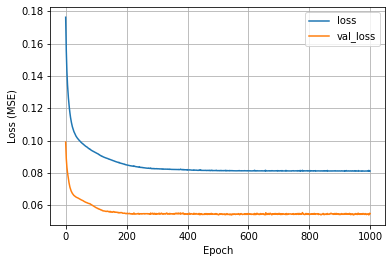

In [ ]:
plot_loss(deeper_model_history)

## Wider Model

In [ ]:
neurons = 50
epoch = 1000
batch_size =32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.0981 - val_loss: 0.0610
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0924 - val_loss: 0.0589
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0893 - val_loss: 0.0575
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0873 - val_loss: 0.0566
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0861 - val_loss: 0.0559
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0853 - val_loss: 0.0557
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0555
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0839 - val_loss: 0.0552
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0549
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0830 - val_loss: 0.0550
Epoch 11/1000
9/9 

In [ ]:
wider_model_dataframe = pd.DataFrame(wider_model_history.history)
wider_model_dataframe['epoch'] = wider_model_history.epoch
wider_model_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
21,0.081269,0.054013,21
24,0.081293,0.054039,24
22,0.081088,0.054158,22
23,0.080993,0.054222,23
58,0.080482,0.054265,58
...,...,...,...
535,0.080227,0.056449,535
3,0.087324,0.056599,3
2,0.089281,0.057459,2
1,0.092449,0.058872,1


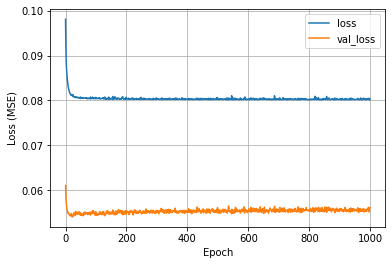

In [ ]:
plot_loss(wider_model_history)

## LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

epoch = 1000
batch_size = 32

feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
9/9 [==============================] - 0s 29ms/step - loss: 0.1095 - val_loss: 0.0679
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.1066 - val_loss: 0.0663
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.1044 - val_loss: 0.0651
Epoch 4/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1025 - val_loss: 0.0640
Epoch 5/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.1007 - val_loss: 0.0632
Epoch 6/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0992 - val_loss: 0.0624
Epoch 7/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0978 - val_loss: 0.0615
Epoch 8/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0963 - val_loss: 0.0608
Epoch 9/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0949 - val_loss: 0.0601
Epoch 10/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0935 - val_loss: 0.0595
Epoch 11/1000
9/9 

In [ ]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
57,0.080583,0.054201,57
56,0.080714,0.054218,56
61,0.080551,0.054247,61
111,0.080450,0.054258,111
157,0.080502,0.054267,157
...,...,...,...
4,0.100697,0.063178,4
3,0.102462,0.064048,3
2,0.104413,0.065112,2
1,0.106595,0.066323,1


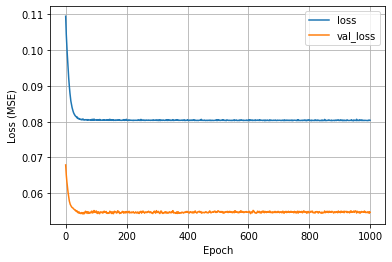

In [ ]:
plot_loss(lstm_model_history)

# Kesimpulan

Dari data di atas, didapatkan hasil:

*   Baseline Model 	   	    
loss 0.087380	
val_loss 0.056723	
epcoh 136

*   Deeper Model
loss 0.081511	
Val_loss 0.053988	
epoch 995	

*   Wider Model    
loss 0.081269	
val_loss 0.054013	
epoch 21

*   LSTM           
loss 0.080583	
val_loss 0.054201	
epoch 57

Nilai validation loss terkecil ada pada Wider Model epoch 21.Perbedaan hasil validation loss dan epoch setiap model cukup besar. Hal ini berarti dari awal model yang diberikan, neurons yang dikasih terlalu kecil. Pada deeper model sendiri validation loss didapatkan pada epoch ke 995, meningkat dari hasil baseline model namun ditemukan pada epoch yang cukup besar berarti untuk kedalaman layer dapat diabaikan sehingga faktor yang menentukan adalah lebar neuron yang diberikan. Pada model LSTM sendiri hasilnya tidak jauh berbeda dengan wider model pada nilai validation loss, sedangkan untuk nilai loss training lebih baik pada LSTM. Pada wider model dan LSTM masing-masing epoch ditemukan pada epoch ke 21 dan ke 57,  mungkin dengan memakai LSTM mungkin nilai loss dan validation loss yang dihasilkan bisa lebih kecil, namun pada dataset ini memakai wider model sudah cukup untuk menghasilkan validation loss terbaik. 